# Assignment 2: Fashion Dataset and Architecture Comparisons

In this assignment, you are to perform the following:

1. Study the `FashionMNIST` dataset, and understand the images and their respective labels.
1. Implement a `Trainer` class in the file `trainer_lib.py` for reusable and reproducible training loops.
1. Implement the following architectures:
  - Linear model
  - MLP with one hidden layer
  - Simple convolution with pooling
  - Deep convolution with pooling, followed by MLP with one hidden layer.

In [1]:
"🔒"
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchsummaryX import summary
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In this section, you will simply run the following data loading cells to familiarize yourself with the layout and semantics of the training dataset.

In [2]:
"🔒"
#
# Loading data
#
home = os.environ.get('HOME')
root = os.path.join(home, 'public/data')
dataset = torchvision.datasets.FashionMNIST(
    root,
    train=True,
    transform=torchvision.transforms.ToTensor())

dataset

RuntimeError: Dataset not found. You can use download=True to download it

The first image is of shape: torch.Size([1, 28, 28])
The first label is: 9


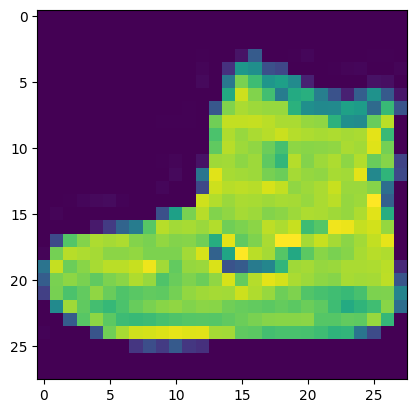

In [ ]:
"🔒"
#
# Print out important stats about the dataset
#
image_tensor, label = dataset[0]
print("The first image is of shape:", image_tensor.shape)
print("The first label is:", label)

plt.imshow(np.transpose(image_tensor, (1, 2, 0)));

The dataset object has a `.classes` field that contains the names of
the different labels.  It has 10 classes ranging from **T-shirt** to **Ankle boot**.

In [ ]:
"🔒"
#
# Print the lookup
#
lookup = pd.Series({x: i for (i,x) in enumerate(dataset.classes)})
lookup

T-shirt/top    0
Trouser        1
Pullover       2
Dress          3
Coat           4
Sandal         5
Shirt          6
Sneaker        7
Bag            8
Ankle boot     9
dtype: int64

In fact, we can print the first 36 entries in the dataset, and plot them as a grid.
Below is the result of that.

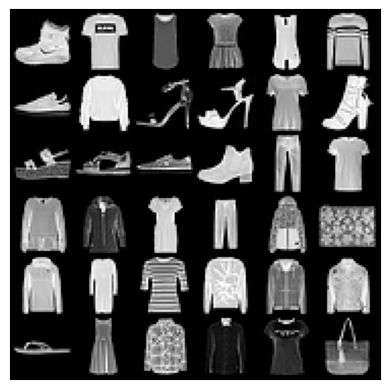

In [ ]:
"🔒"
xs = dataset.data[:36]
xs = xs.reshape(36, 1, 28, 28)
mosiac = torchvision.utils.make_grid(xs, nrow=6)
mosiac = np.transpose(mosiac, (1, 2, 0))
plt.imshow(mosiac)
plt.xticks([])
plt.yticks([]);

## Getting ready for training and validation

We will be using the same training data for all three neural network architectures.

The `train_dataloader` is a dataloader for the training dataset, and `val_dataloader` is the dataloader for the validation dataset.

In [ ]:
"🔒"
train_dataset, val_dataset = random_split(dataset, (0.8, 0.2))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

## Linear classifier

In this section, you will implement a simple linear model.  The linear model is to be implemented as a `nn.Module`
and should have a field `model` which is a `nn.Sequential` module.

You are to complete the implementation by creating two layers in the `nn.Sequence(...)`:

- A layer to flatten the input from `(1,28,28)` to a vector.
- The second layer perform linear classification to 10 dimensional logit.  You are to use the `nn.LazyLinear` layer to implement
  the linear layer.  The advantage of the `LazyLinear` layer is that you do not need to compute
  the input dimension explicitly.

In [ ]:
"✍️"
# @workUnit

class MyLinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # complete the architecture
            nn.Flatten(),
            nn.LazyLinear(10),
        )
    def forward(self, image):
        return self.model(image)

In [ ]:
"🔒"
# @check
# @title: check linear model architecture

m = MyLinear()
xs, ys = next(iter(train_dataloader))
summary(m, xs);

                     Kernel Shape Output Shape Params Mult-Adds
Layer                                                          
0_model.Flatten_0               -    [32, 784]      -         -
1_model.LazyLinear_1    [784, 10]     [32, 10]  7.85k     7.84k
-----------------------------------------------------------------
                      Totals
Total params           7.85k
Trainable params       7.85k
Non-trainable params     0.0
Mult-Adds              7.84k


## A trainer class

In this section, you will be implementing a trainer class that will be used throughout the assignment.

The trainer class has the following methods:

**Constructor:**

- Input:
  - `model`: a `nn.Module` that is the neural network model.
  - `train_dataloader`: a `DataLoader` that is the training data
  - `val_dataloader`: is the `Dataloader` for validation
  - The constructor uses the `optim.Adam(...)` as the optimizer.
  - The constructor uses the `nn.CrossEntropy` as the loss function.
  
**`Trainer.train_one_epoch`**:

It performs training of `model` for **one epoch** by iterating over the batches from `train_dataloader`.

- Input:
  - `max_batches` is the maximum batches taken from the dataloader.  **For performance reasons, we will only sample 10 batches.**
  
- Output: it returns two float numbers:
  - mean loss over the batches
  - mean accuracy over the batches
  
**`Trainer.val_one_epoch`**:

It performs validation by iterating over all batches from the validation dataloader.

- Output: it returns two float numbers:
  - mean loss
  - mean accuracy
  
**`Trainer.train`**

This method performs training.

- Input:
  - `epochs`: the number of epochs.
  - `max_batches`: the maximum batches to take per epoch.
- Output:
  returns a `DataFrame` containing training loss,
  training accuracy, validation loss, validation accuracy, and the time per epoch.
  
**`Trainer.reset`**

This method resets the trainable parameters of the model.

**A skeleton implementation is given in `trainer_lib.py`.**  You are to complete the implementation.

In [ ]:
"🔒"
import trainer_lib

Below are some basic sanity checks of the trainer implementation.

In [ ]:
"🔒"
# @check
# @title: check trainer construction
reload(trainer_lib)
trainer = trainer_lib.Trainer(m, train_dataloader, val_dataloader)
print(trainer is not None)

True


In [ ]:
"🔒"
# @check
# @title: check trainer methods
for method in ['train_one_epoch', 'val_one_epoch', 'train', 'reset']:
    print(f"trainer.{method}?", hasattr(trainer, method))

trainer.train_one_epoch? True
trainer.val_one_epoch? True
trainer.train? True
trainer.reset? True


In [ ]:
"🔒"
# @check
# @title: check trainer.train_one_epoch

(loss, acc) = trainer.train_one_epoch(max_batches=1)
print('loss is numeric', isinstance(loss, float))
print('acc is numeric', isinstance(acc, float))

loss is numeric True
acc is numeric True


In [ ]:
"🔒"
# @check
# @title: check trainer.val_one_epoch

(loss, acc) = trainer.val_one_epoch()
print('loss is numeric', isinstance(loss, float))
print('acc is numeric', isinstance(acc, float))

loss is numeric True
acc is numeric True


In [ ]:
"🔒"
# @check
# @title: check trainer.reset

trainer.reset()
print("Ok")

Ok


## Training the linear model

In this section, we will train the linear model.  We will take 10 batches per epoch, and train for 20 epochs.

The training history is stored in `model_linear_log`.

This will take approximately **70 seconds**.

In [ ]:
"🔒"
reload(trainer_lib)

model_linear = MyLinear()
trainer = trainer_lib.Trainer(model_linear, train_dataloader, val_dataloader)
trainer.reset()
model_linear_log = trainer.train(epochs=20, max_batches=10)
model_linear_log.round(2)

[0 (3.17s)]: train_loss=2.08 train_acc=0.24, val_loss=1.83 val_acc=0.28
[1 (3.60s)]: train_loss=1.68 train_acc=0.41, val_loss=1.48 val_acc=0.61
[2 (3.26s)]: train_loss=1.42 train_acc=0.59, val_loss=1.26 val_acc=0.64
[3 (2.97s)]: train_loss=1.22 train_acc=0.64, val_loss=1.14 val_acc=0.67
[4 (3.57s)]: train_loss=1.14 train_acc=0.60, val_loss=1.05 val_acc=0.67
[5 (3.31s)]: train_loss=1.00 train_acc=0.66, val_loss=1.00 val_acc=0.65
[6 (3.30s)]: train_loss=0.96 train_acc=0.67, val_loss=0.95 val_acc=0.69
[7 (3.58s)]: train_loss=0.93 train_acc=0.69, val_loss=0.91 val_acc=0.70
[8 (3.07s)]: train_loss=0.93 train_acc=0.72, val_loss=0.89 val_acc=0.71
[9 (3.44s)]: train_loss=0.86 train_acc=0.72, val_loss=0.86 val_acc=0.71
[10 (3.30s)]: train_loss=0.83 train_acc=0.72, val_loss=0.85 val_acc=0.71
[11 (3.18s)]: train_loss=0.87 train_acc=0.72, val_loss=0.82 val_acc=0.74
[12 (3.02s)]: train_loss=0.85 train_acc=0.74, val_loss=0.81 val_acc=0.73
[13 (2.91s)]: train_loss=0.83 train_acc=0.71, val_loss=0.79 v

,train_loss,train_accuracy,val_loss,val_accuracy,epoch_duration
0,2.08,0.24,1.83,0.28,3.17
1,1.68,0.41,1.48,0.61,3.60
2,1.42,0.59,1.26,0.64,3.26
3,1.22,0.64,1.14,0.67,2.97
4,1.14,0.60,1.05,0.67,3.57
5,1.00,0.66,1.00,0.65,3.31
6,0.96,0.67,0.95,0.69,3.30
7,0.93,0.69,0.91,0.70,3.58
8,0.93,0.72,0.89,0.71,3.07
9,0.86,0.72,0.86,0.71,3.44


## MLP Models

In this section, you are to construct a MLP model.  It uses `LazyLinear` to create a hidden dimension of 50, with activation `nn.ReLU` for the hidden layer.

In [ ]:
"✍️"
# @workUnit

class MLPModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # complete the following
            nn.Flatten(),
            nn.LazyLinear(50),
            nn.ReLU(),
            nn.LazyLinear(10),
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
"🔒"
# @check
# @title: MLP model architecture

model_mlp = MLPModel()
summary(model_mlp, xs);

                     Kernel Shape Output Shape  Params Mult-Adds
Layer                                                           
0_model.Flatten_0               -    [32, 784]       -         -
1_model.LazyLinear_1    [784, 50]     [32, 50]  39.25k     39.2k
2_model.ReLU_2                  -     [32, 50]       -         -
3_model.LazyLinear_3     [50, 10]     [32, 10]   510.0     500.0
------------------------------------------------------------------
                      Totals
Total params          39.76k
Trainable params      39.76k
Non-trainable params     0.0
Mult-Adds              39.7k


## Training MLP

We will train the MLP model in 20 epochs with 10 batches per epoch.

You should expect:

- Total training time: 80 seconds
- Final validation accuracy approximately 75% or higher.

In [ ]:
"🔒"
model_mlp = MLPModel()
reload(trainer_lib)
trainer = trainer_lib.Trainer(model_mlp, train_dataloader, val_dataloader)
trainer.reset()
model_mlp_log = trainer.train(epochs=20, max_batches=10)
model_mlp_log.round(2)

[0 (4.67s)]: train_loss=2.17 train_acc=0.22, val_loss=2.01 val_acc=0.39
[1 (5.68s)]: train_loss=1.86 train_acc=0.40, val_loss=1.71 val_acc=0.43
[2 (4.80s)]: train_loss=1.56 train_acc=0.57, val_loss=1.46 val_acc=0.59
[3 (4.90s)]: train_loss=1.29 train_acc=0.64, val_loss=1.27 val_acc=0.62
[4 (5.31s)]: train_loss=1.28 train_acc=0.59, val_loss=1.15 val_acc=0.65
[5 (3.50s)]: train_loss=1.08 train_acc=0.65, val_loss=1.07 val_acc=0.64
[6 (5.19s)]: train_loss=1.00 train_acc=0.67, val_loss=0.95 val_acc=0.70
[7 (4.30s)]: train_loss=0.96 train_acc=0.69, val_loss=0.91 val_acc=0.68
[8 (3.50s)]: train_loss=0.89 train_acc=0.70, val_loss=0.86 val_acc=0.70
[9 (5.60s)]: train_loss=0.92 train_acc=0.69, val_loss=0.85 val_acc=0.72
[10 (4.81s)]: train_loss=0.93 train_acc=0.65, val_loss=0.80 val_acc=0.73
[11 (4.20s)]: train_loss=0.76 train_acc=0.78, val_loss=0.80 val_acc=0.71
[12 (4.69s)]: train_loss=0.79 train_acc=0.74, val_loss=0.77 val_acc=0.72
[13 (4.24s)]: train_loss=0.76 train_acc=0.71, val_loss=0.74 v

,train_loss,train_accuracy,val_loss,val_accuracy,epoch_duration
0,2.17,0.22,2.01,0.39,4.67
1,1.86,0.40,1.71,0.43,5.68
2,1.56,0.57,1.46,0.59,4.80
3,1.29,0.64,1.27,0.62,4.90
4,1.28,0.59,1.15,0.65,5.31
5,1.08,0.65,1.07,0.64,3.50
6,1.00,0.67,0.95,0.70,5.19
7,0.96,0.69,0.91,0.68,4.30
8,0.89,0.70,0.86,0.70,3.50
9,0.92,0.69,0.85,0.72,5.60


## Convolution based networks

In this section, we will construct a simple convolutional network.  It consists of the following layers:

- 2D convolution with the `num_kernels` kernels of size `kernel_size`.
- Max pooling with pooling size `pool_size`.
- ReLU activation
- Flatten the max pooling output to a vector
- A (lazy) linear layer that maps to 10 dimensional logits vector

In [ ]:
"✍️"
# @workUnit

class LinearCNNModel(nn.Module):
    def __init__(self, num_kernels, kernel_size, pool_size):
        super().__init__()
        self.model = nn.Sequential(
            # complete the following
            nn.Conv2d(1, num_kernels, kernel_size, padding='same'),
            nn.MaxPool2d(pool_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, x):
        return self.model(x)

We will construct a convolutional network with 5 kernels, with kernel size 3, and pooling size of 2.

In [ ]:
"🔒"
# @check
# @title: CNN Linear architecture

model_cnn_linear = LinearCNNModel(5, 3, 2)
summary(model_cnn_linear, xs);

                      Kernel Shape     Output Shape Params Mult-Adds
Layer                                                               
0_model.Conv2d_0      [1, 5, 3, 3]  [32, 5, 28, 28]   50.0    35.28k
1_model.MaxPool2d_1              -  [32, 5, 14, 14]      -         -
2_model.ReLU_2                   -  [32, 5, 14, 14]      -         -
3_model.Flatten_3                -        [32, 980]      -         -
4_model.LazyLinear_4     [980, 10]         [32, 10]  9.81k      9.8k
----------------------------------------------------------------------
                      Totals
Total params           9.86k
Trainable params       9.86k
Non-trainable params     0.0
Mult-Adds             45.08k


## Training of Convolutional Network

We will train a convolutional network using 20 epochs, and 10 batches per epoch.

You should expect:

- Total training time: 120 seconds
- Validation accuracy approximately 76% or higher.

In [ ]:
"🔒"
reload(trainer_lib)
trainer = trainer_lib.Trainer(model_cnn_linear, train_dataloader, val_dataloader)
trainer.reset()
model_cnn_linear_log = trainer.train(epochs=20, max_batches=10)
model_cnn_linear_log.round(2)

[0 (8.97s)]: train_loss=2.19 train_acc=0.22, val_loss=2.02 val_acc=0.40
[1 (6.70s)]: train_loss=1.90 train_acc=0.47, val_loss=1.74 val_acc=0.61
[2 (8.00s)]: train_loss=1.65 train_acc=0.56, val_loss=1.47 val_acc=0.62
[3 (7.13s)]: train_loss=1.37 train_acc=0.66, val_loss=1.25 val_acc=0.63
[4 (6.85s)]: train_loss=1.16 train_acc=0.67, val_loss=1.08 val_acc=0.69
[5 (7.12s)]: train_loss=1.00 train_acc=0.72, val_loss=0.97 val_acc=0.70
[6 (8.41s)]: train_loss=0.90 train_acc=0.72, val_loss=0.88 val_acc=0.71
[7 (7.70s)]: train_loss=0.85 train_acc=0.70, val_loss=0.84 val_acc=0.72
[8 (7.68s)]: train_loss=0.78 train_acc=0.72, val_loss=0.80 val_acc=0.73
[9 (8.40s)]: train_loss=0.78 train_acc=0.72, val_loss=0.77 val_acc=0.73
[10 (7.80s)]: train_loss=0.73 train_acc=0.74, val_loss=0.75 val_acc=0.74
[11 (7.00s)]: train_loss=0.76 train_acc=0.74, val_loss=0.71 val_acc=0.76
[12 (8.21s)]: train_loss=0.72 train_acc=0.76, val_loss=0.71 val_acc=0.75
[13 (7.19s)]: train_loss=0.63 train_acc=0.77, val_loss=0.69 v

,train_loss,train_accuracy,val_loss,val_accuracy,epoch_duration
0,2.19,0.22,2.02,0.40,8.97
1,1.90,0.48,1.74,0.61,6.70
2,1.65,0.56,1.47,0.62,8.00
3,1.37,0.66,1.25,0.63,7.13
4,1.16,0.67,1.08,0.69,6.85
5,1.00,0.72,0.97,0.70,7.12
6,0.90,0.72,0.88,0.71,8.41
7,0.85,0.70,0.84,0.72,7.70
8,0.78,0.72,0.80,0.73,7.68
9,0.78,0.72,0.77,0.73,8.40


## Deep Conv model

We will construct a **deep convolutional** network with the following layers:

- Conv2d with 16 kernels of size 5, with `padding='same'`
- MaxPool2d with pooling size of 2
- Conv2d with 32 kernels of size 3, with padding
- MaxPool2d with pooling size of 2
- Flatten the maxpooling output to a vector
- a MLP with hidden layer of 50, and ReLU is used as the activation function, and its output layer produces the 10 dimensional logits vector

In [ ]:
"✍️"
# @workUnit

class DeepCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # complete the following
            nn.Conv2d(1, 16, 5, padding='same'),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(50),
            nn.ReLU(),
            nn.LazyLinear(10)
            
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
"🔒"
# @check
# @title: deep cnn architecture

model_cnn_deep = DeepCNNModel()
summary(model_cnn_deep, xs);

                        Kernel Shape      Output Shape  Params Mult-Adds
Layer                                                                   
0_model.Conv2d_0       [1, 16, 5, 5]  [32, 16, 28, 28]   416.0    313.6k
1_model.MaxPool2d_1                -  [32, 16, 14, 14]       -         -
2_model.Conv2d_2      [16, 32, 3, 3]  [32, 32, 14, 14]   4.64k  903.168k
3_model.MaxPool2d_3                -    [32, 32, 7, 7]       -         -
4_model.Flatten_4                  -        [32, 1568]       -         -
5_model.LazyLinear_5      [1568, 50]          [32, 50]  78.45k     78.4k
6_model.ReLU_6                     -          [32, 50]       -         -
7_model.LazyLinear_7        [50, 10]          [32, 10]   510.0     500.0
--------------------------------------------------------------------------
                         Totals
Total params            84.016k
Trainable params        84.016k
Non-trainable params        0.0
Mult-Adds             1.295668M


## Training the deep CNN network

We train the deep convolutional network.

You should expect:

- Total training time: 250 seconds
- Validation accuracy should be close to or exceeds 80%.

In [ ]:
"🔒"
reload(trainer_lib)
trainer = trainer_lib.Trainer(model_cnn_deep, train_dataloader, val_dataloader)
trainer.reset()
model_cnn_deep_log = trainer.train(epochs=20, max_batches=10)
model_cnn_deep_log.round(2)

[0 (16.08s)]: train_loss=2.16 train_acc=0.17, val_loss=1.93 val_acc=0.31
[1 (14.90s)]: train_loss=1.62 train_acc=0.37, val_loss=1.36 val_acc=0.49
[2 (15.51s)]: train_loss=1.20 train_acc=0.58, val_loss=1.03 val_acc=0.63
[3 (13.59s)]: train_loss=0.99 train_acc=0.65, val_loss=0.90 val_acc=0.67
[4 (13.20s)]: train_loss=0.84 train_acc=0.66, val_loss=0.85 val_acc=0.67
[5 (14.89s)]: train_loss=0.76 train_acc=0.72, val_loss=0.91 val_acc=0.70
[6 (13.80s)]: train_loss=0.87 train_acc=0.71, val_loss=0.84 val_acc=0.68
[7 (13.71s)]: train_loss=0.66 train_acc=0.74, val_loss=0.75 val_acc=0.71
[8 (13.90s)]: train_loss=0.78 train_acc=0.74, val_loss=0.78 val_acc=0.72
[9 (14.19s)]: train_loss=0.80 train_acc=0.71, val_loss=0.69 val_acc=0.75
[10 (14.30s)]: train_loss=0.65 train_acc=0.74, val_loss=0.70 val_acc=0.75
[11 (14.10s)]: train_loss=0.66 train_acc=0.73, val_loss=0.68 val_acc=0.75
[12 (12.61s)]: train_loss=0.67 train_acc=0.73, val_loss=0.70 val_acc=0.76
[13 (14.20s)]: train_loss=0.66 train_acc=0.77, v

,train_loss,train_accuracy,val_loss,val_accuracy,epoch_duration
0,2.16,0.18,1.93,0.31,16.08
1,1.62,0.37,1.36,0.49,14.90
2,1.20,0.58,1.03,0.63,15.51
3,0.99,0.65,0.90,0.67,13.59
4,0.84,0.66,0.85,0.67,13.20
5,0.76,0.72,0.91,0.70,14.89
6,0.87,0.71,0.84,0.68,13.80
7,0.66,0.74,0.75,0.71,13.71
8,0.78,0.74,0.78,0.72,13.90
9,0.80,0.71,0.69,0.75,14.19


## Plot

The following plots the training accuracy.

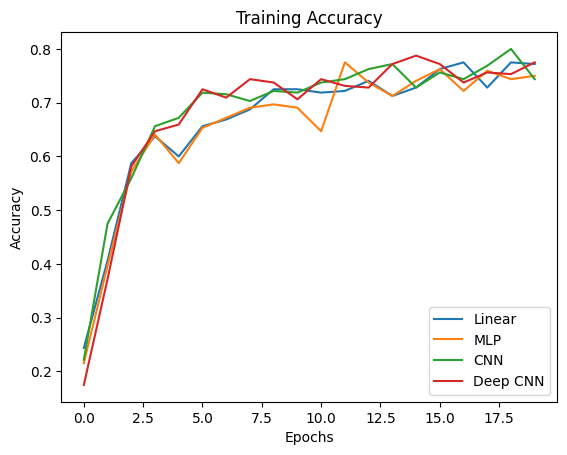

In [ ]:
"🔒"
plt.figure()
plt.plot(model_linear_log.index, model_linear_log.train_accuracy)
plt.plot(model_mlp_log.index, model_mlp_log.train_accuracy)
plt.plot(model_cnn_linear_log.index, model_cnn_linear_log.train_accuracy)
plt.plot(model_cnn_deep_log.index, model_cnn_deep_log.train_accuracy)

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Linear', 'MLP', 'CNN', 'Deep CNN']);

### Plot the validation accuracy

Make sure you properly label the plot and the axes.

In [ ]:
"✍️"
# @workUnit

#
# Generate the validation accuracy of the different models
#

'✍️'